


<div style="text-align:center;">
    <img src="https://i.imgur.com/1v2C2o7.png" alt="Image Description">
</div>


<div style="text-align:center;">
<h1><strong> Harmful Brain Activity Classification</strong></h1>
    <h2>Harvard Medical School</h2> </div>

# Objectives and Goal
* To detect and classify seizures and other types of harmful brain activity in critical ill patients.
* To develop a model trained on electroencephalography (EEG) signals recorded from critically ill hospital patients.
* To create a model that can automates EEG analysis will help doctors and brain researchers detect seizures and other types of brain activity that can cause brain damage, so that they can give treatments more quickly and accurately. 
* May also help researchers who are working to develop drugs to treat and prevent seizures.


<h2> Dataset Flowchart </h2>
<a href="https://imgur.com/9pvOTk6"><img src="https://i.imgur.com/9pvOTk6.png" title="source: imgur.com" /></a>

## Patterns for Classification:
1. Seizure (SZ)
2. Generalized periodic discharges (GPD)
3. Lateralized periodic discharges (LPD)
4. Lateralized rhythmic delta activity (LRDA)
5. Generalized rhythmic delta activity (GRDA)
6. Other

##### Detailed explanation of above patterns:
* https://www.acns.org/UserFiles/file/ACNSStandardizedCriticalCareEEGTerminology_rev2021.pdf 


* In some cases experts completely agree about the correct label. On other cases the experts disagree. They call segments where there are high levels of agreement “idealized” patterns. Cases where ~1/2 of experts give a label as “other” and ~1/2 give one of the remaining five labels, we call “proto patterns”. Cases where experts are approximately split between 2 of the 5 named patterns, we call “edge cases”.

1. High level of agreement                        - Idealized pattern
2. Half of experts give a label                    - Other
3. Half of experts give one of the remaining five label      - proto patterns
4. Experts split between 2 of the 5 named patterns - edge cases

## Import Libraries


In [1]:
import os
os.environ["KERAS_BACKEND"] = "jax"
import pandas as pd
import numpy as np
import keras_cv
import keras
import matplotlib.pyplot as plt
import seaborn as sns
import shutil
from tqdm.notebook import tqdm
from concurrent.futures import ProcessPoolExecutor
from sklearn.model_selection import StratifiedGroupKFold
import tensorflow as tf
from keras.callbacks import LearningRateScheduler
from sklearn.metrics import classification_report, confusion_matrix, precision_score, recall_score
import warnings
warnings.filterwarnings("ignore")



2024-03-18 14:02:25.901597: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-03-18 14:02:25.901721: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-03-18 14:02:26.036818: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
#Using two GPUs
strategy =tf.distribute.MirroredStrategy()
print('DEVICE AVALABLE: {}'. format(strategy.num_replicas_in_sync))

# Use mixed precision
tf.config.optimizer.set_experimental_options({"auto_mixed_precision": True})

DEVICE AVALABLE: 2


In [3]:
!pip install -q /kaggle/input/kerasv3-lib-ds/keras_cv-0.8.2-py3-none-any.whl --no-deps
!pip install -q /kaggle/input/kerasv3-lib-ds/tensorflow-2.15.0.post1-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl --no-deps
!pip install -q /kaggle/input/kerasv3-lib-ds/keras-3.0.4-py3-none-any.whl --no-deps

In [4]:
import tensorflow as tf
print("TensorFlow:", tf.__version__)

import keras
print("Keras:", keras.__version__)

import keras_cv
print("KerasCV:", keras_cv.__version__)


TensorFlow: 2.15.0
Keras: 3.0.5
KerasCV: 0.8.2


# Load the Train Data CSV

* The CSV files contain metadata that provide additional information about the EEG recordings and spectrograms. 
* This metadata has details such as unique identifiers, timestamps, patient IDs, and labels assigned by experts.
* Use this information to organize and label train data, map EEG recordings to their corresponding spectrograms, and understand the characteristics of the dataset.

In [5]:
train_df = pd.read_csv("/kaggle/input/hms-harmful-brain-activity-classification/train.csv")
print('Train shape', train_df.shape )
display( train_df.head() )

Train shape (106800, 15)


eeg_id  eeg_sub_id  eeg_label_offset_seconds  spectrogram_id  \
0  1628180742           0                       0.0          353733   
1  1628180742           1                       6.0          353733   
2  1628180742           2                       8.0          353733   
3  1628180742           3                      18.0          353733   
4  1628180742           4                      24.0          353733   

   spectrogram_sub_id  spectrogram_label_offset_seconds    label_id  \
0                   0                               0.0   127492639   
1                   1                               6.0  3887563113   
2                   2                               8.0  1142670488   
3                   3                              18.0  2718991173   
4                   4                              24.0  3080632009   

   patient_id expert_consensus  seizure_vote  lpd_vote  gpd_vote  lrda_vote  \
0       42516          Seizure             3         0         0          0   
1       42516          Seizure             3         0         0          0   
2       42516          Seizure             3         0         0          0   
3       42516          Seizure             3         0         0          0   
4       42516          Seizure             3         0         0          0   

   grda_vote  other_vote  
0          0           0  
1          0           0  
2          0           0  
3          0           0  
4          0           0

## Label to the Multiple Classes

In [6]:
# Target columns stored in a variable
target_classes = [col for col in train_df.columns if col.endswith("_vote")]
print(list(target_classes))


class_names = ['Seizure', 'LPD', 'GPD', 'LRDA','GRDA', 'Other']
label_dict =dict(enumerate(class_names ))
class_label = {j:i for i, j in label_dict.items()}
# print(class_label)

# Give Label to the classes 
train_df['target_name'] = train_df.expert_consensus.copy()
train_df['target_labels'] = train_df.expert_consensus.map(class_label)
# train_df.head(1)

['seizure_vote', 'lpd_vote', 'gpd_vote', 'lrda_vote', 'grda_vote', 'other_vote']


In [7]:
print("Total Train Observation    :", len(train_df))
print("Unique EEG ID              :", train_df['eeg_id'].nunique())
print("Unique Spectrogram ID      :", train_df['spectrogram_id'].nunique())
print("Total Patients Data        :", train_df['patient_id'].nunique())
print("Unique Label ID            :", train_df['label_id'].nunique())
print("Classes names             :",  train_df['target_name'].unique())
print("Count of Expert cosensus   :", train_df['expert_consensus'].value_counts())


Total Train Observation    : 106800
Unique EEG ID              : 17089
Unique Spectrogram ID      : 11138
Total Patients Data        : 1950
Unique Label ID            : 106800
Classes names             : ['Seizure' 'GPD' 'LRDA' 'Other' 'GRDA' 'LPD']
Count of Expert cosensus   : expert_consensus
Seizure    20933
GRDA       18861
Other      18808
GPD        16702
LRDA       16640
LPD        14856
Name: count, dtype: int64


In [8]:
# Set random seed
tf.random.set_seed(42)

# Read Train EEG and Spectrogram Data
<a href="https://imgur.com/kf1sLtK"><img src="https://i.imgur.com/kf1sLtK.png" title="source: imgur.com" /></a>

In [9]:
# Paths
base_path = "/kaggle/input/hms-harmful-brain-activity-classification"
train_eeg_path = os.path.join(base_path, "train_eegs")
train_spec_path = os.path.join(base_path, "train_spectrograms")


In [10]:
# Get first file
spec_file = os.listdir(train_spec_path)
file= spec_file[0]
print(file)

# DIsplay first file of train spectrograms
train_parquet1 = pd.read_parquet(f'{train_spec_path}/{file}')
train_parquet1.head(2)

# pd.set_option("display.max_columns",None)
# train_parquet1

32728416.parquet


time    LL_0.59    LL_0.78    LL_0.98    LL_1.17    LL_1.37    LL_1.56  \
0     1  42.840000  64.959999  74.739998  68.199997  65.529999  49.970001   
1     3  71.879997  76.199997  92.510002  59.869999  52.480000  36.360001   

     LL_1.76  LL_1.95  LL_2.15  ...  RP_18.16  RP_18.36  RP_18.55  RP_18.75  \
0  26.570000    10.67     8.13  ...      0.04      0.03      0.02      0.04   
1  22.139999    11.69     7.05  ...      0.05      0.04      0.03      0.03   

   RP_18.95  RP_19.14  RP_19.34  RP_19.53  RP_19.73  RP_19.92  
0      0.04      0.03      0.02      0.02      0.03      0.03  
1      0.04      0.04      0.03      0.03      0.02      0.02  

[2 rows x 401 columns]

## Visualize the Spectrogram data

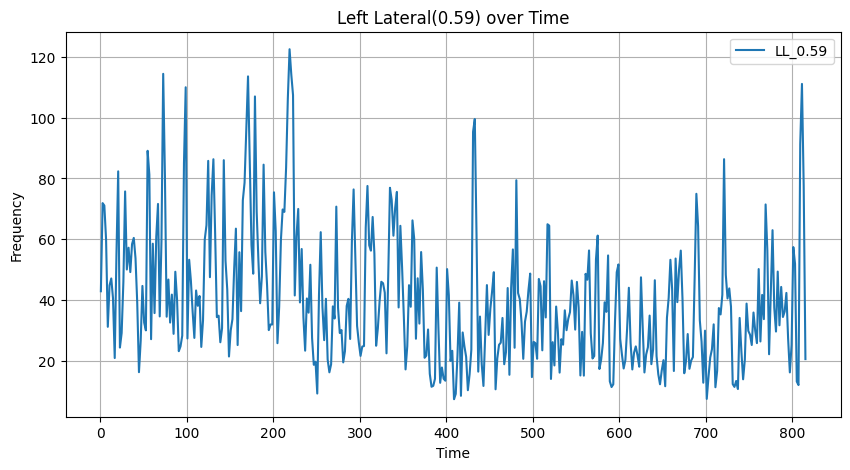

In [11]:
## Visualize the single LL0.59 column of 32728416.parquet spectrogram file
plt.figure(figsize=(10, 5))  
plt.plot(train_parquet1['time'], train_parquet1['LL_0.59'], label='LL_0.59')
plt.xlabel('Time')
plt.ylabel('Frequency')
plt.title('Left Lateral(0.59) over Time')
plt.legend()
plt.grid(True)
plt.show()

### Read first EEG file

* EEG Data: The EEG recordings contain electrical activity data captured from electrodes placed on the scalp. 

In [12]:
# Get first file
eeg_file = os.listdir(train_eeg_path)
file= eeg_file[0]
print(file)

# DIsplay first file of train EEG
train_parquet_eeg = pd.read_parquet(f'{train_eeg_path}/{file}')
train_parquet_eeg.head(2)

2208063991.parquet


Fp1         F3         C3         P3    F7         T3         T5  \
0  18.870001  26.049999  35.619999  52.369999 -3.19  40.410000  39.080002   
1  23.930000  28.980000  37.750000  52.900002  1.86  44.130001  39.340000   

      O1         Fz    Cz         Pz        Fp2         F4    C4     P4    F8  \
0  11.43  24.190001  7.98  59.279999 -33.230000  26.049999  2.39  16.48  3.46   
1  10.63  25.250000  5.85  56.889999 -31.629999  26.049999  2.13  13.56  2.13   

     T4         T6           O2         EKG  
0  3.72 -19.940001 -4848.370117  488.609985  
1  7.44 -23.389999 -4859.799805  498.450012

## Visualize the EEG Data

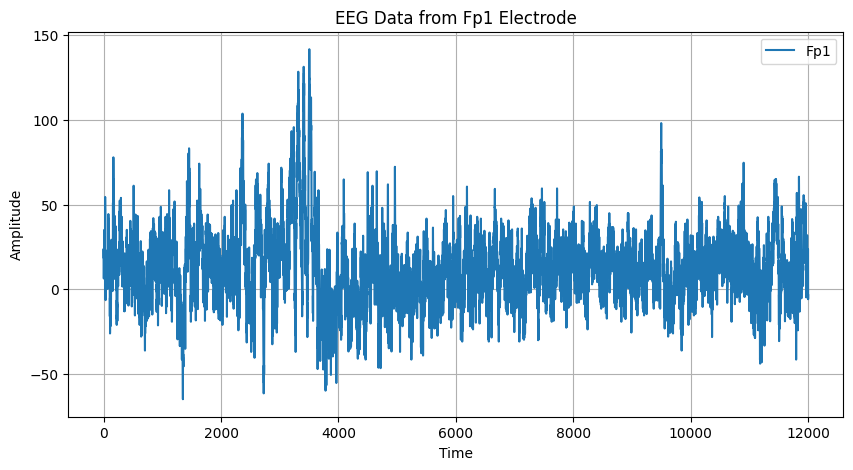

In [13]:
## Visualize the single Fp1 electrode of 2208063991.parquet EEG file
plt.figure(figsize=(10,5))
plt.plot(train_parquet_eeg["Fp1"], label = "Fp1") 
plt.xlabel('Time')
plt.ylabel('Amplitude')
plt.title('EEG Data from Fp1 Electrode')
plt.legend()
plt.grid(True)
plt.show()

# <h1><strong> Explanatory Analysis</strong></h1>

## Class distribution based on experts votes

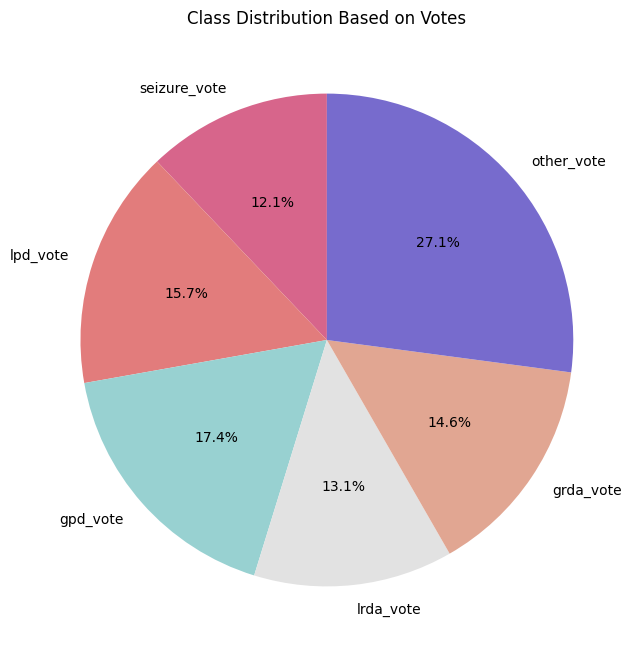

In [14]:
# Calculate class distribution based on votes
class_distribution = train_df[['seizure_vote', 'lpd_vote', 'gpd_vote', 'lrda_vote', 'grda_vote', 'other_vote']].sum()

a=["#d7658b", "#e27c7c", "#98d1d1",  "#e2e2e2", "#e1a692",  "#776bcd"]
# Plotting the pie chart
plt.figure(figsize=(8, 8))
plt.pie(class_distribution, labels=class_distribution.index, autopct='%1.1f%%', startangle=90, colors=a)
plt.title('Class Distribution Based on Votes')
plt.show()


Based on the provided percentages, the class distribution appears moderately imbalanced, with the "Other" class being the most dominant. 

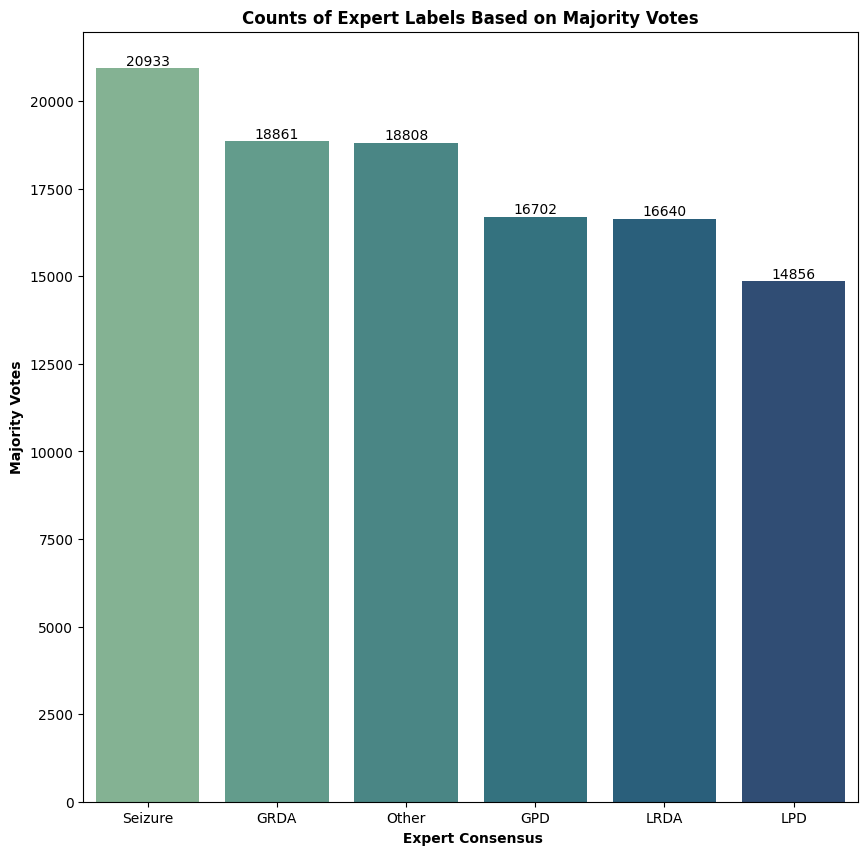

In [15]:
## Barplot of expert's label based on the majority votes to the labes
max_expert_consensus_votes = train_df["expert_consensus"].value_counts()
plt.figure(figsize=(10, 10))
sns.barplot(x=max_expert_consensus_votes.index, y=max_expert_consensus_votes.values, palette = 'crest')
plt.title("Counts of Expert Labels Based on Majority Votes", fontsize=12, fontweight = 'bold')
plt.xlabel(" Expert Consensus", fontsize=10, fontweight = 'bold')
plt.ylabel( "Majority Votes", fontsize=10, fontweight = 'bold')

# Add labels to the bars
for index, value in enumerate(max_expert_consensus_votes):
    plt.text(index, value + 0.5, str(value), ha='center', va='bottom')
size=1
# Show the plot
plt.show()

<h1><strong> 1.Feature Engineering </strong>
    <br><br>Using Below Information </h1>

1. High level of agreement                        - Idealized pattern
2. Half of experts give a label                    - Other
3. Half of experts give remaining five label      - proto patterns
4. Experts split between 2 of the 5 named patterns - edge cases

In [16]:
# function to generate the new column based on the rules to understand the data
def generate_pattern_type(df):
    votes = [df['seizure_vote'], df['lpd_vote'], df['gpd_vote'], df['lrda_vote'], df['grda_vote']]
    total_votes = sum(votes)
    max_vote = max(votes)
    other_vote = df['other_vote']
    
    # Rule 1: All experts agreed on one label
    if  total_votes == max_vote:
        return 'Idealized'
    # Rule 2: ~1/2 of experts give a label as "other" and ~1/2 give one of the remaining five labels
             ## used abs() to avoid negative numbers
    elif abs(other_vote - total_votes / 2) <= 1 and max_vote == total_votes / 2:
        return 'Proto'
    # Rule 3: Experts are approximately split between 2 of the 5 named patterns
    elif max_vote >= total_votes / 2  or len([vote for vote in votes if vote == max_vote]) == 2:
        return 'Edge '
    else:
        return 'Undefined'  # other label for cases not covered by the rules

# Apply the function 
train_df['pattern_type'] = train_df.apply(generate_pattern_type, axis=1)

# # Display the DataFrame with the new column
train_df.head(2)


eeg_id  eeg_sub_id  eeg_label_offset_seconds  spectrogram_id  \
0  1628180742           0                       0.0          353733   
1  1628180742           1                       6.0          353733   

   spectrogram_sub_id  spectrogram_label_offset_seconds    label_id  \
0                   0                               0.0   127492639   
1                   1                               6.0  3887563113   

   patient_id expert_consensus  seizure_vote  lpd_vote  gpd_vote  lrda_vote  \
0       42516          Seizure             3         0         0          0   
1       42516          Seizure             3         0         0          0   

   grda_vote  other_vote target_name  target_labels pattern_type  
0          0           0     Seizure              0    Idealized  
1          0           0     Seizure              0    Idealized

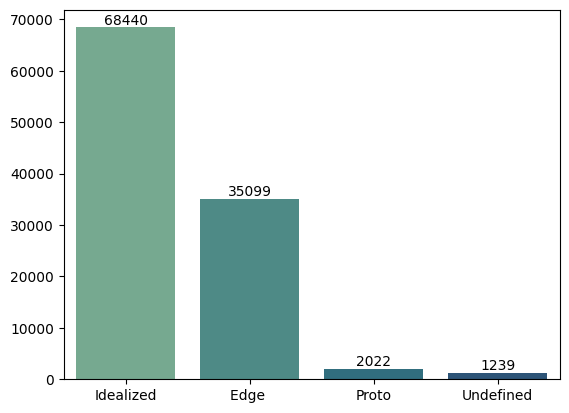

In [17]:
value = train_df['pattern_type'].value_counts().values
sns.barplot(x= train_df['pattern_type'].unique(), y=value , palette ='crest')

for i, value in enumerate(value):
    plt.text(i, value +0.5, str(value), ha= 'center', va='bottom')

## Visualize Spectrogram Data Based On Idealized Pattern Category

In [18]:
#  Get Unique spectrogram_id with the Idealized pattern types
unique_spectrogram_ids = train_df['spectrogram_id'].unique()
idealized_pattern_data = train_df[train_df['pattern_type'] == 'Idealized'].reset_index(drop=True)

idealized_pattern_data

# define number of spectrogram to display in each row
n=3

# initialize an empty dictionary to store the list of spectrogram ids for each idealized pattern category
spec_dict = {
    "seizure_vote": [],
    "lpd_vote": [],
    "gpd_vote": [],
    "lrda_vote": [],
    "grda_vote": [],
    "other_vote": []
}


for key in spec_dict.keys():
    #sort the spectrogrram based on the category and select the top 3
    idx = idealized_pattern_data[key].sort_values(ascending= False).head(n).index
    spec_dict[key] = idealized_pattern_data.loc[idx, "spectrogram_id"].values
    
# spec_dict

* Convert the EEG signals into spectrogram images. You can use libraries like matplotlib or scipy to generate spectrograms from the EEG signals.

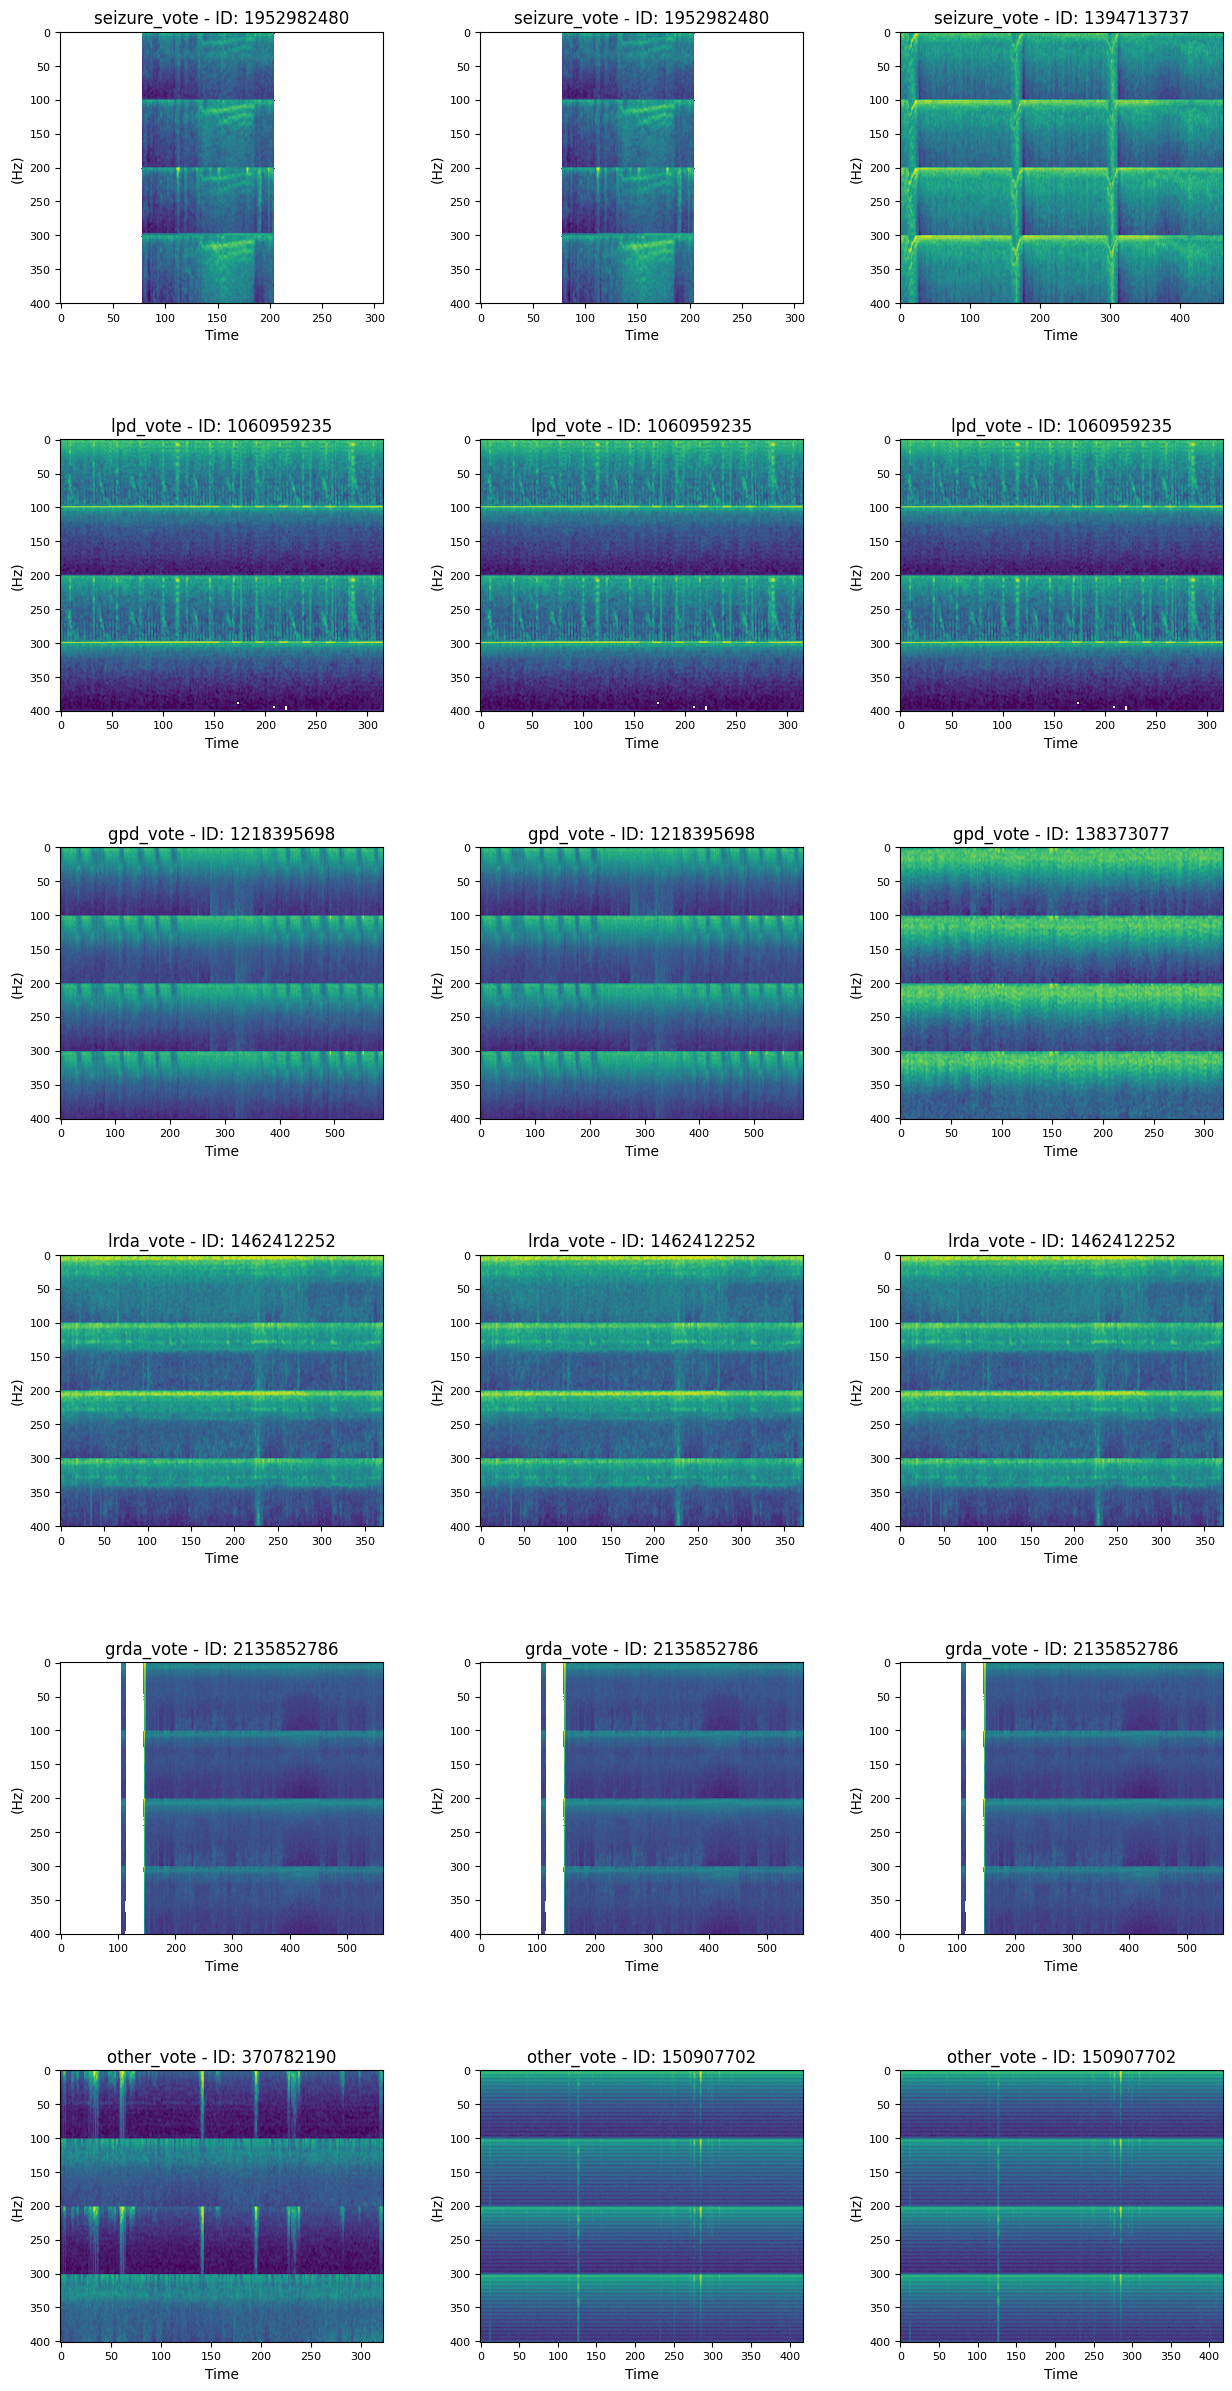

In [19]:
def plot_spectrogram_by_cateogry(spect_dict):
    train_spec_path = "/kaggle/input/hms-harmful-brain-activity-classification/train_spectrograms/"

    fig, axes = plt.subplots(len(spec_dict), n, figsize= (15, len(spec_dict)*5))
    plt.subplots_adjust(wspace=0.3, hspace=0.5)
    
    for i , (key, values) in enumerate(spec_dict.items()):
        for j, value in enumerate(values):
            
            spec_data = pd.read_parquet(train_spec_path + str(value) + '.parquet')
            #plot the spectrogram
            ax = axes[i, j]
            ax.imshow(np.log(spec_data.T), aspect ='auto')
            ax.set_title(f"{key} - ID: {value}", size=12)
            ax.set_xlabel("Time", size=10)
            ax.set_ylabel("(Hz)", size=10)
            ax.tick_params(axis='both', which='both', labelsize=8)
            
    plt.show()

plot_spectrogram_by_cateogry(spec_dict)
            

### Adding EEG and Spectrogram Paths to the Train CSV DataFrame
*  Adding 'eeg_path' and 'spec_path' columns to the train_df can efficiently scale model to handle larger datasets without being limited by memory constraints. This scalability is essential for handling real-world large datasets .
* 'eeg_path' provides the location of the EEG data files associated with each 'eeg_id'. This allows the model to access the actual data when needed for training or evaluation.
* 'spec_path' provides the location of the spectrogram data files associated with 'spec_id. This allows the model to access the actual data during training or evaluation.

In [20]:
#  Using string concatenation  method creating the eeg_path ans spec-path columns by looping corresponding ids
train_df['eeg_path'] = train_eeg_path+'/' +  train_df['eeg_id'].astype(str) + '.parquet'
train_df['original_spec_path'] = train_spec_path + '/' + train_df['spectrogram_id'].astype(str) + '.parquet'

# #Display
train_df.head(1)

eeg_id  eeg_sub_id  eeg_label_offset_seconds  spectrogram_id  \
0  1628180742           0                       0.0          353733   

   spectrogram_sub_id  spectrogram_label_offset_seconds   label_id  \
0                   0                               0.0  127492639   

   patient_id expert_consensus  seizure_vote  lpd_vote  gpd_vote  lrda_vote  \
0       42516          Seizure             3         0         0          0   

   grda_vote  other_vote target_name  target_labels pattern_type  \
0          0           0     Seizure              0    Idealized   

                                            eeg_path  \
0  /kaggle/input/hms-harmful-brain-activity-class...   

                                  original_spec_path  
0  /kaggle/input/hms-harmful-brain-activity-class...

## Convert spectrogram .parquet file into the numpy

#### Reasons:
* Compatibility: Tensorflow and pytorch expect the input data to be in the form of Numpy arrays.
* Efficient Data Loading: NumPy arrays are stored in a binary format, which allows for faster loading compared to text-based formats like Parquet.Since working with larger dataset as it reduce the overhead associated with data loading and improves overall training efficiency.
* Ease of Manipulation: NumPy arrays provide a convenient interface for performing various operations and manipulations on the data, such as normalization, reshaping, and augmentation.

In [21]:

# # # Run this code to delete the working data before generating saving the new npy data to remove the space

# Specify the directory path
directory_path = "/tmp/dataset/hms-hbac"
# Check if the directory exists before attempting to delete it
if os.path.exists(directory_path):
    shutil.rmtree(directory_path)  # Use shutil.rmtree() to remove a directory and its contents
    print(f"Directory '{directory_path}' and its contents have been deleted successfully.")
else:
    print(f"Directory '{directory_path}' does not exist.")

Directory '/tmp/dataset/hms-hbac' does not exist.


### Store the coverted numpy files into the temprory memory

In [22]:

# #Define a function to process with single spectrogram file
def process_spectrogram(spec_id, base_path,split = 'train'):
    spec_path =os.path.join(base_path, f"{split}_spectrograms", f"{spec_id}.parquet")
    spec_df = pd.read_parquet(spec_path)
    spec_values = spec_df.fillna(0).values[:, 1:].T.astype(np.float32)
    spec_dir = os.path.join("/tmp/dataset/hms-hbac", f"{split}_spectrograms")
    os.makedirs(spec_dir, exist_ok=True)
    
    np.save(os.path.join(spec_dir,f"{spec_id}.npy"),spec_values)
 
 # Define a function to process spectrograms
def process_spec_wrapper(spec_id):
    process_spectrogram(spec_id, base_path, split='train')

# Get unique spectrogram IDs
spec_ids = train_df['spectrogram_id'].unique()

# Create a ProcessPoolExecutor with a specified number of processes
with ProcessPoolExecutor() as executor:
    # Submit the process_spec_wrapper function to the executor for each spectrogram ID
    list(tqdm(executor.map(process_spec_wrapper, spec_ids), total=len(spec_ids)))   

  0%|          | 0/11138 [00:00<?, ?it/s]

### Add Spectrogram numpy file path to the train dataframe

In [23]:
numpy_spec_path = "/tmp/dataset/hms-hbac/train_spectrograms/"
train_df['spec_path_numpy'] = f'{numpy_spec_path}' + train_df['spectrogram_id'].astype(str) + '.npy'


## Handle Imbalanced Data

Using **"StratifiedGroupKFold"** from **"sklearn.model_selection"** for dealing with imbalanced datasets because it prevents one class from being overly represented or underrepresented in any given fold.


In [24]:
sgkf = StratifiedGroupKFold(n_splits = 5, shuffle = True, random_state = 42)
# Assign the fold the data
train_df["fold"] =-1
train_df.reset_index(drop=True, inplace=True)
for fold, (_, valid_idx) in enumerate(sgkf.split(train_df, y=train_df['target_labels'], groups = train_df['patient_id'])):
    train_df.loc[valid_idx, "fold"] = fold
    
#to display  the all columns of fold
pd.set_option('display.max_columns', None)

# fold group by the eed_id and expert consensus
counts = train_df.groupby(["fold", "expert_consensus"])[["eeg_id"]].count().T

# display the ocunt
counts

fold                 0                                     1              \
expert_consensus   GPD  GRDA   LPD  LRDA Other Seizure   GPD  GRDA   LPD   
eeg_id            2050  2605  1168  3793  3462    4007  4832  4856  4463   

fold                                     2                                  \
expert_consensus  LRDA Other Seizure   GPD  GRDA   LPD  LRDA Other Seizure   
eeg_id            3117  3851    4383  5386  3389  2658  2432  3598    3711   

fold                 3                                     4              \
expert_consensus   GPD  GRDA   LPD  LRDA Other Seizure   GPD  GRDA   LPD   
eeg_id            2545  4311  2318  4296  3884    4787  1889  3700  4249   

fold                                  
expert_consensus  LRDA Other Seizure  
eeg_id            3002  4013    4045

In [25]:
## Splits the data into training and validation sets based on a specified fold
sample_df = train_df.groupby('spectrogram_id').head(1).reset_index(drop=True)
train = sample_df[sample_df.fold != 0]
valid = sample_df[sample_df.fold == 0]
print(f"# Num Train: {len(train)} | Num Valid: {len(valid)}")

# Num Train: 9166 | Num Valid: 1972


### Function for Augmentation, to generate Dataset and Preprocess the Images
 * Decoding an image which involves converting the image from its raw format into a format that can be processed by the machine learning model. 

In [26]:

def build_augmenter(dim=[400,300]):
    augmenters =[
        keras_cv.layers.RandomCutout(height_factor=(0.5, 0.8), width_factor=(0.2, 0.4)), 
        keras_cv.layers.RandomCutout(height_factor=(0.2, 0.4), width_factor=(0.2, 0.4)), 
        keras_cv.layers.RandomFlip(),
        keras_cv.layers.CutMix()
    ]

    def augment(img, labels):
        inputs = {"images": img, "labels": labels}
        data =inputs
        for aug in augmenters:
            if tf.random.uniform([]) < 0.5:
                data = aug(data, training=True)
        return data["images"], data["labels"]
    
    return augment

In [27]:
def build_decoder(with_labels=True, target_size=[400,300], dtype=32):
    def decode_signal(path, offset=None):
        # Read .npy files and process the signal
        file_bytes = tf.io.read_file(path)
        sig = tf.io.decode_raw(file_bytes, tf.float32)
        sig = sig[1024//dtype:]  # Remove header tag
        sig = tf.reshape(sig, [400, -1])
        
        # Extract labeled subsample from full spectrogram using "offset"
        if offset is not None: 
            offset = offset // 2  # Only odd values are given
            sig = sig[:, offset:offset+300]
            
            # Pad spectrogram to ensure the same input shape of [400, 300]
            pad_size = tf.math.maximum(0, 300 - tf.shape(sig)[1])
            sig = tf.pad(sig, [[0, 0], [0, pad_size]])
            sig = tf.reshape(sig, [400, 300])
        
        # Log spectrogram 
        sig = tf.clip_by_value(sig, tf.math.exp(-4.0), tf.math.exp(8.0)) # avoid 0 in log
        sig = tf.math.log(sig)
        
        # Normalize spectrogram
        sig -= tf.math.reduce_mean(sig)
        sig /= tf.math.reduce_std(sig) + 1e-6
        
        # Mono channel to 3 channels to use "ImageNet" weights
        sig = tf.tile(sig[..., None], [1, 1, 3])
        return sig
    
    def decode_label(label):
        label = tf.one_hot(label, 6)
        label = tf.cast(label, tf.float32)
        label = tf.reshape(label, [6])
        return label
    
    def decode_with_labels(path, offset=None, label=None):
        sig = decode_signal(path, offset)
        label = decode_label(label)
        return (sig, label)
    
    return decode_with_labels if with_labels else decode_signal


def create_dataset(paths, offsets=None, labels=None, batch_size=32, cache=True,
                  decode_fn=None, augment_fn=None,
                  augment=False, repeat=True, shuffle=1024, 
                  cache_dir="", drop_remainder=False):
    if cache_dir != "" and cache is True:
        os.makedirs(cache_dir, exist_ok=True)
    
    if decode_fn is None:
        decode_fn = build_decoder(labels is not None)
    
    if augment_fn is None:
        augment_fn = build_augmenter()
    
    AUTO = tf.data.experimental.AUTOTUNE
    slices = (paths, offsets) if labels is None else (paths, offsets, labels)
    
    ds = tf.data.Dataset.from_tensor_slices(slices)
    ds = ds.map(decode_fn, num_parallel_calls=AUTO)
    ds = ds.cache(cache_dir) if cache else ds
    ds = ds.repeat() if repeat else ds
    if shuffle: 
        ds = ds.shuffle(shuffle, seed=42)
        opt = tf.data.Options()
        opt.experimental_deterministic = False
        ds = ds.with_options(opt)
    ds = ds.batch(batch_size, drop_remainder=drop_remainder)
    ds = ds.map(augment_fn, num_parallel_calls=AUTO) if augment else ds
    ds = ds.prefetch(AUTO)
    return ds

In [28]:
train_paths = train["spec_path_numpy"].values
train_offsets = train["spectrogram_label_offset_seconds"].astype(int)
train_labels = train["target_labels"].values
#Apply the data generate function the train dataset
train_ds = create_dataset(train_paths, offsets=train_offsets, labels=train_labels, batch_size=64, cache=True,
                  augment=True,repeat=True, shuffle=True)


valid_paths = valid["spec_path_numpy"].values
valid_offsets = valid["spectrogram_label_offset_seconds"].values.astype(int)
valid_labels = valid["target_labels"].values
#Apply the data generate function the valid dataset. In valid dataset augementation, shuffle, repeate are not applied.
valid_ds = create_dataset(valid_paths, offsets=valid_offsets, labels=valid_labels, batch_size=64, cache=True,
                   augment=False,repeat=False, shuffle=False)


## Check image channels after Augmentation

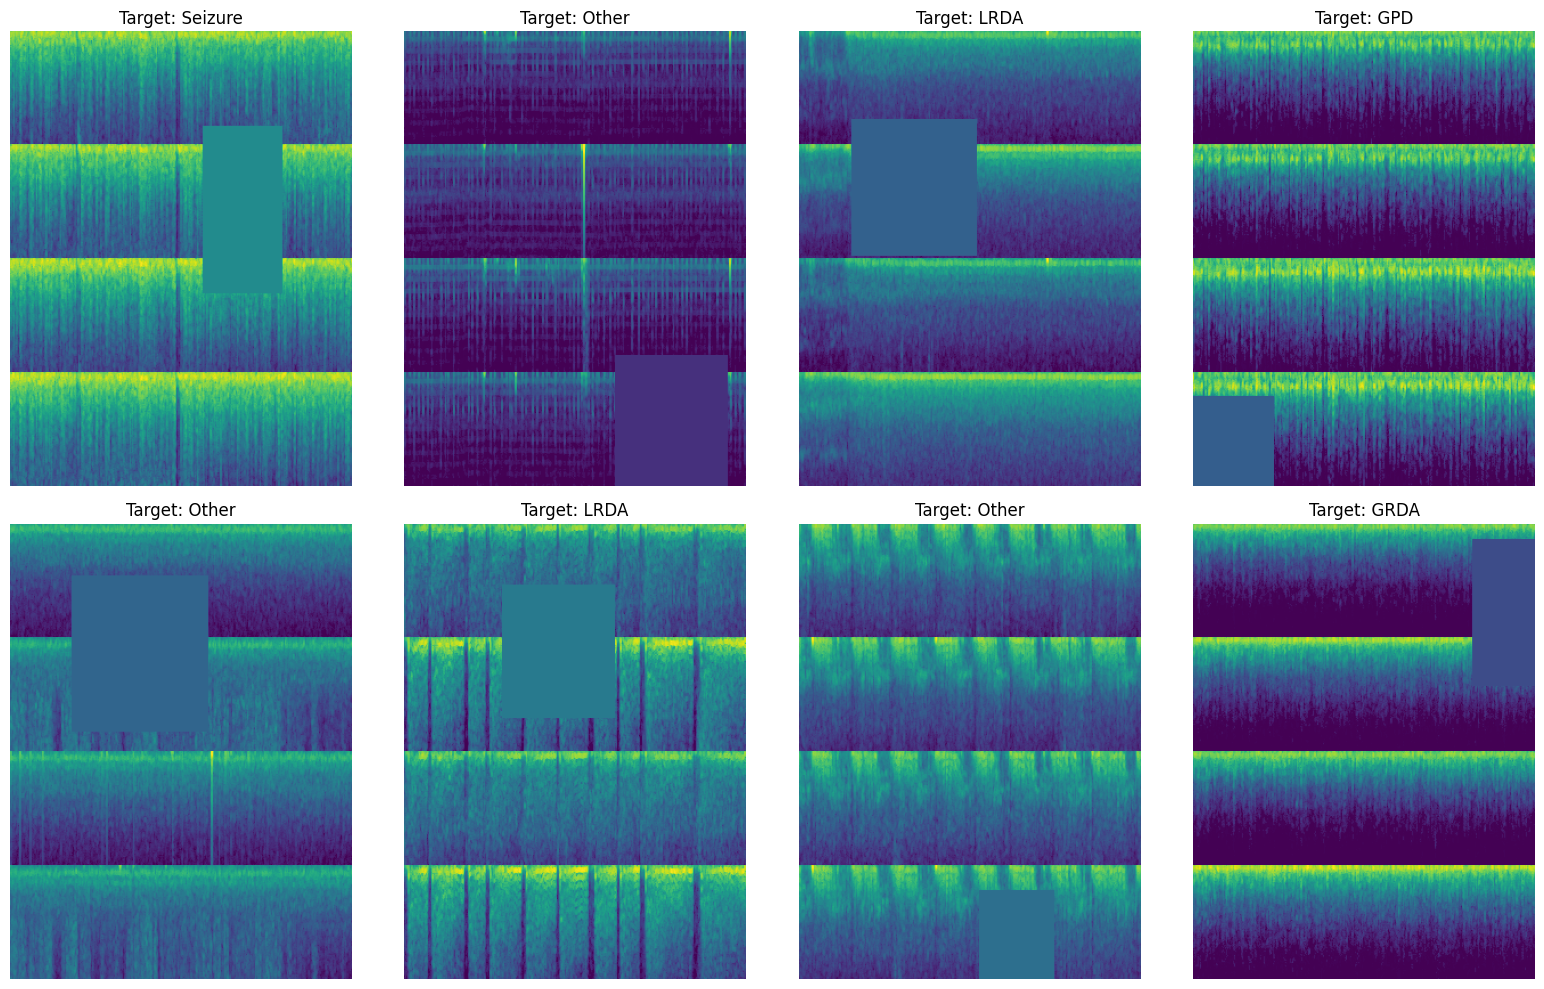

In [29]:
names = ['Seizure', 'LPD', 'GPD', 'LRDA','GRDA', 'Other']
label_name = dict(enumerate(names))
imgs, tars = next(iter(train_ds))

num_imgs = 8
plt.figure(figsize=(4*4, num_imgs//4*5))
for i in range(num_imgs):
    plt.subplot(num_imgs//4, 4, i + 1)
    img = imgs[i].numpy()[...,0]  # Adjust as per your image data format
    img -= img.min()
    img /= img.max() + 1e-4
    tar = label_name[np.argmax(tars[i].numpy())]
    plt.imshow(img)
    plt.title(f"Target: {tar}")
    plt.axis('off')
    
plt.tight_layout()
plt.show()

# <strong>EfficientNetV2 Model</strong>

## Build Model Using Keras Image Classifier

In [30]:

# Build Classifier    
model = keras_cv.models.ImageClassifier.from_preset(
   "efficientnetv2_b2_imagenet", num_classes=6
)    

with strategy.scope():
    inp = tf.keras.layers.Input((400,300,3))
    backbone = keras_cv.models.EfficientNetV2Backbone.from_preset(
        "efficientnetv2_b2_imagenet"
    )
    x = backbone(inp)
    
    # Add classification head
    x = keras.layers.GlobalAveragePooling2D()(x)
    output = keras.layers.Dense(6, activation='softmax', dtype='float32')(x)

loss = tf.keras.losses.KLDivergence()

# Compile the model within the scope of the strategy
with strategy.scope():
    model.compile(optimizer=keras.optimizers.Adam(learning_rate=1e-5),
                  loss=loss, metrics=['accuracy'])

#display the summary of model
model.summary()

Attaching 'config.json' from model 'keras/efficientnetv2/keras/efficientnetv2_b2_imagenet/2' to your Kaggle notebook...
Attaching 'config.json' from model 'keras/efficientnetv2/keras/efficientnetv2_b2_imagenet/2' to your Kaggle notebook...
Attaching 'model.weights.h5' from model 'keras/efficientnetv2/keras/efficientnetv2_b2_imagenet/2' to your Kaggle notebook...
Attaching 'config.json' from model 'keras/efficientnetv2/keras/efficientnetv2_b2_imagenet/2' to your Kaggle notebook...
Attaching 'config.json' from model 'keras/efficientnetv2/keras/efficientnetv2_b2_imagenet/2' to your Kaggle notebook...
Attaching 'model.weights.h5' from model 'keras/efficientnetv2/keras/efficientnetv2_b2_imagenet/2' to your Kaggle notebook...


Model: "image_classifier"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, None, None, 3)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ efficient_net_v2b2_backbone     │ (None, None, None,     │     8,769,374 │
│ (EfficientNetV2Backbone)        │ 1408)                  │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ avg_pool                        │ (None, 1408)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ predictions (Dense)             │ (None, 6)              │         8,454 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 8,777,828 (33.48 MB)

 Trainable params: 8,695,540 (33.17 MB)

 Non-trainable params: 82,288 (321.44 KB)

## Customize Learning Rate function base on the number of epoch

In [31]:
def piecewise_constant_decay(epoch):
    if epoch < 5:
        return 0.01
    elif epoch < 10:
        return 0.005
    elif epoch < 15:
        return 0.001
    else:
        return 0.0005

lr_scheduler = LearningRateScheduler(piecewise_constant_decay)

## Model checkpoint
callback = keras.callbacks.ModelCheckpoint('best_model.keras.weights.h5',
                                             monitor ='val_loss',
                                             verbose=0,
                                             save_best_only=True,
                                            save_weights_only=True,
                                            mode="min")

In [32]:
tf.random.set_seed(1)
# train the model
h1 = model.fit(
    train_ds, 
    batch_size = 64,
    epochs=15,
    validation_data = valid_ds,
    callbacks = [lr_scheduler,callback],
    steps_per_epoch=len(train)//64,
      verbose=1
)

Epoch 1/15
143/143 ━━━━━━━━━━━━━━━━━━━━ 311s 2s/step - accuracy: 0.4039 - loss: 1.3858 - val_accuracy: 0.4163 - val_loss: 1.4521 - learning_rate: 0.0100
Epoch 2/15
143/143 ━━━━━━━━━━━━━━━━━━━━ 200s 1s/step - accuracy: 0.5225 - loss: 1.1175 - val_accuracy: 0.5624 - val_loss: 1.2192 - learning_rate: 0.0100
Epoch 3/15
143/143 ━━━━━━━━━━━━━━━━━━━━ 189s 1s/step - accuracy: 0.5617 - loss: 1.0477 - val_accuracy: 0.5974 - val_loss: 1.1255 - learning_rate: 0.0100
Epoch 4/15
143/143 ━━━━━━━━━━━━━━━━━━━━ 193s 1s/step - accuracy: 0.5742 - loss: 0.9903 - val_accuracy: 0.6298 - val_loss: 1.0633 - learning_rate: 0.0100
Epoch 5/15
143/143 ━━━━━━━━━━━━━━━━━━━━ 192s 1s/step - accuracy: 0.5823 - loss: 0.9525 - val_accuracy: 0.6202 - val_loss: 1.1170 - learning_rate: 0.0100
Epoch 6/15
143/143 ━━━━━━━━━━━━━━━━━━━━ 196s 1s/step - accuracy: 0.5930 - loss: 0.8962 - val_accuracy: 0.6207 - val_loss: 1.1173 - learning_rate: 0.0050
Epoch 7/15
143/143 ━━━━━━━━━━━━━━━━━━━━ 191s 1s/step - accuracy: 0.6382 - loss: 0.

In [33]:
model.load_weights("best_model.keras.weights.h5")

# <strong>Train and Validation Loss Plot</strong>

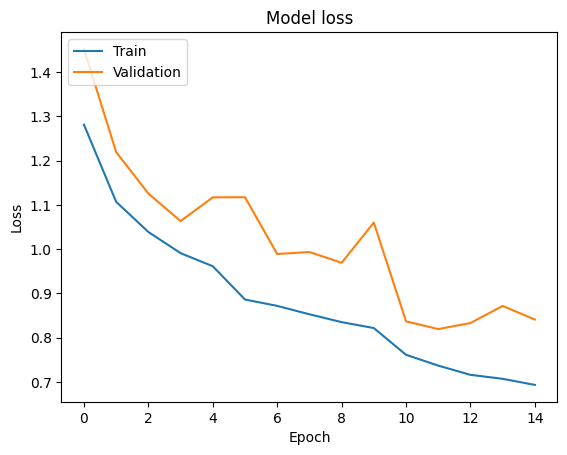

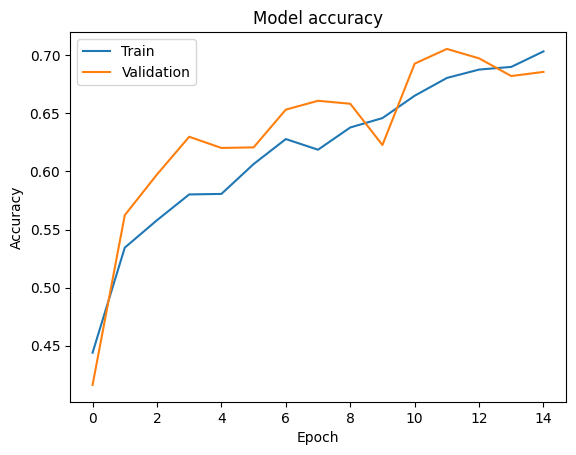

In [34]:
# Plot training & validation loss values
plt.plot(h1.history['loss'])
plt.plot(h1.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Plot training & validation accuracy values
plt.plot(h1.history['accuracy'])
plt.plot(h1.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()


# ResNet152

# <strong> Classification Report </strong>
## Prediction on Validation Data

In [35]:
## Predict on Validation Data
prediction = model.predict(valid_ds)
predicted_prob = np.argmax(prediction, axis=1)
target_labels = valid_labels

31/31 ━━━━━━━━━━━━━━━━━━━━ 15s 332ms/step


In [36]:
names = ['Seizure', 'LPD', 'GPD', 'LRDA','GRDA', 'Other']
print("Classification Report:")
print(classification_report(target_labels, predicted_prob, target_names=names))

# Calculate confusion matrix
print("Confusion Matrix:")
print(confusion_matrix(target_labels, predicted_prob))

# Calculate precision
precision = precision_score(target_labels, predicted_prob, average='weighted')
print("Precision:", precision)

# Calculate recall
recall = recall_score(target_labels, predicted_prob, average='weighted')
print("Recall:", recall)


Classification Report:
              precision    recall  f1-score   support

     Seizure       0.79      0.69      0.73       360
         LPD       0.63      0.64      0.63       170
         GPD       0.63      0.67      0.65       130
        LRDA       0.67      0.46      0.55       130
        GRDA       0.55      0.55      0.55       235
       Other       0.74      0.80      0.77       947

    accuracy                           0.71      1972
   macro avg       0.67      0.63      0.65      1972
weighted avg       0.71      0.71      0.70      1972

Confusion Matrix:
[[247  14   2   9  13  75]
 [  8 108  12   0   1  41]
 [  4  13  87   0   1  25]
 [  5   8   0  60  14  43]
 [  9   2  10   7 130  77]
 [ 41  27  28  14  78 759]]
Precision: 0.705651540524847
Recall: 0.7053752535496958


# <strong>TEST DATASET </strong>

In [37]:
# Read the test dataset
test_df = pd.read_csv("/kaggle/input/hms-harmful-brain-activity-classification/test.csv")
test_df.shape

(1, 3)

## Read Spectrogram and EEG of Test Data

In [38]:
## Define path of all test files
test_spec = "/kaggle/input/hms-harmful-brain-activity-classification/test_spectrograms"
test_eeg = "/kaggle/input/hms-harmful-brain-activity-classification/train_eegs"

In [39]:
# # Get eeg file
# eeg_file = os.listdir(test_eeg)
# f =eeg_file[0]


# # Display test EEG
# eeg_f = pd.read_parquet(f'{test_eeg}/{f}')
# eeg_f .head(2)
# # eeg_f .shape

In [40]:
# Get spec file
# spec_file = os.listdir(test_spec)
# f =spec_file[0]

# Display test EEG
# spec_f = pd.read_parquet(f'{test_spec}/{f}')
# spec_f .head(2)
# spec_f .shape

## Visualize the test spectrogram id

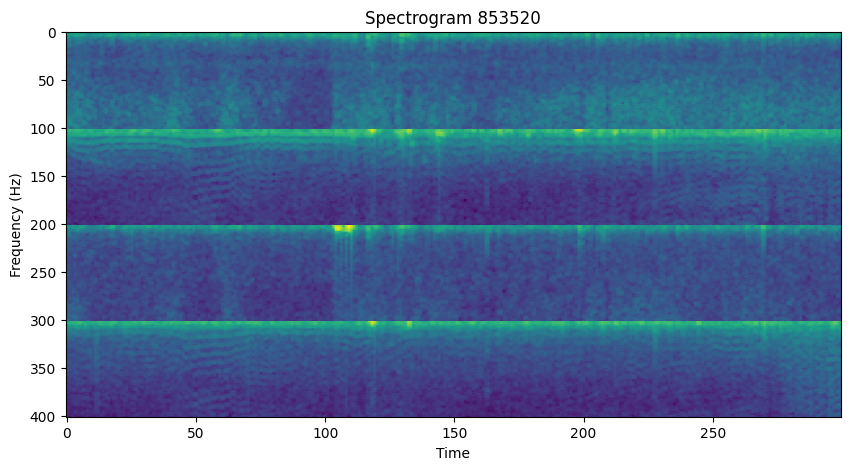

In [41]:
#Fucntions to load the spec and eeg data
def load_spectrogram(path):
    file = pd.read_parquet(path)
    return file

#Apply function to the spec id
spec_data = load_spectrogram(test_spec)

#Plot the spectrogram
plt.figure(figsize=(10,5))
plt.imshow(np.log(spec_data.T),aspect ='auto')
plt.title('Spectrogram 853520')
plt.xlabel('Time')
plt.ylabel('Frequency (Hz)')
plt.show()

## Feature Engineering 
*  Adding 'eeg_path' and 'spec_path' columns to the test_df can efficiently scale model to handle larger datasets without being limited by memory constraints. This scalability is essential for handling real-world large datasets .
* 'eeg_path' provides the location of the EEG data files associated with each 'eeg_id'.
* 'spec_path' provides the location of the spectrogram data files associated with 'spec_id. 

In [42]:
#Get Unique spectrogram ids of test data
 ### Test data has only one spectrogram id
spec_ids_test = test_df['spectrogram_id'].unique()

# Apply process function on test data
for spec_id in spec_ids_test:
    process_spectrogram(spec_id, base_path, split = 'test')

In [43]:
test_df['eeg_path'] = test_eeg+'/' +  test_df['eeg_id'].astype(str) + '.parquet'
test_df['spec_path'] = test_spec+ '/' + test_df['spectrogram_id'].astype(str) + '.parquet'

numpy_test_spec= "/tmp/dataset/hms-hbac/test_spectrograms"
# #Replace the .parquet file to the numpy.
test_df['spec_path_numpy'] = test_df['spectrogram_id'].apply(lambda x: os.path.join(numpy_test_spec , f"{x}.npy"))

#Display the test data 
# test_df

In [44]:
# # Display the converted numpy files
# npy_temp_spec_path = "/tmp/dataset/hms-hbac/test_spectrograms/853520.npy"
# data = np.load(npy_temp_spec_path)
# print(data)

In [45]:
#Get information of the test data
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1 entries, 0 to 0
Data columns (total 6 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   spectrogram_id   1 non-null      int64 
 1   eeg_id           1 non-null      int64 
 2   patient_id       1 non-null      int64 
 3   eeg_path         1 non-null      object
 4   spec_path        1 non-null      object
 5   spec_path_numpy  1 non-null      object
dtypes: int64(3), object(3)
memory usage: 176.0+ bytes


In [46]:
#Applt the preprocess functions to the test data
test_paths = test_df['spec_path_numpy'].values
test_ds = create_dataset(test_paths, batch_size=min(64, len(test_df)),
                         repeat=False, shuffle=False, cache=False)

In [47]:
# Predict on the test data
preds = model.predict(test_ds)

#Display the prediction 
print(preds)

1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step
[[0.07715125 0.11206794 0.0063304  0.27725744 0.08282354 0.4443695 ]]


In [48]:
#Prepare the predicted porbabilties for the submission and convert them into the csv file
pred_df = test_df[["eeg_id"]].copy()
pred_df[target_classes] = preds.tolist()
pred_df[target_classes] 

submission= pd.read_csv(f'{base_path}/sample_submission.csv')
df =submission[["eeg_id"]].copy()
df = df.merge(pred_df, on="eeg_id",how="left")
df.to_csv("submission.csv", index=False)
df

eeg_id  seizure_vote  lpd_vote  gpd_vote  lrda_vote  grda_vote  \
0  3911565283      0.077151  0.112068   0.00633   0.277257   0.082824   

   other_vote  
0    0.444369

# References


* [HMS-HBAC KerasCV Starter Notebook](https://www.kaggle.com/code/awsaf49/hms-hbac-kerascv-starter-notebook)
* [HMS- dataset Analysis Xgboost Classification](https://www.kaggle.com/code/andradaolteanu/hms-dataset-analysis-xgboost-classification)
* [Keras_CV](https://keras.io/keras_cv/)